In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
cities = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [3]:
cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


We are choosing to go ahead with **'Pune, India'** and analyze it's average temperature

In [4]:
indiancities = cities.loc[cities['Country'] == 'India',['dt','City','AverageTemperature']]

In [5]:
punecity = cities.loc[cities['City'] == 'Pune',['dt','City','AverageTemperature']]
punecity

,dt,City,AverageTemperature
6084690,1796-01-01,Pune,20.507
6084691,1796-02-01,Pune,22.483
6084692,1796-03-01,Pune,25.074
6084693,1796-04-01,Pune,28.756
6084694,1796-05-01,Pune,29.944
...,...,...,...
6087298,2013-05-01,Pune,31.024
6087299,2013-06-01,Pune,26.362
6087300,2013-07-01,Pune,24.150
6087301,2013-08-01,Pune,24.444


In [6]:
punecity.columns=['Date','City','Temp']

In [7]:
punecity = punecity.reindex(columns=['Date','Temp','City'])
punecity

,Date,Temp,City
6084690,1796-01-01,20.507,Pune
6084691,1796-02-01,22.483,Pune
6084692,1796-03-01,25.074,Pune
6084693,1796-04-01,28.756,Pune
6084694,1796-05-01,29.944,Pune
...,...,...,...
6087298,2013-05-01,31.024,Pune
6087299,2013-06-01,26.362,Pune
6087300,2013-07-01,24.150,Pune
6087301,2013-08-01,24.444,Pune


In [8]:
punecity['Date'] = pd.to_datetime(punecity['Date'])
punecity

,Date,Temp,City
6084690,1796-01-01,20.507,Pune
6084691,1796-02-01,22.483,Pune
6084692,1796-03-01,25.074,Pune
6084693,1796-04-01,28.756,Pune
6084694,1796-05-01,29.944,Pune
...,...,...,...
6087298,2013-05-01,31.024,Pune
6087299,2013-06-01,26.362,Pune
6087300,2013-07-01,24.150,Pune
6087301,2013-08-01,24.444,Pune


As the entries that covered 'Pune' was a part of the dataframe, the slice came with those specific row entries. So we'll have to reset the index for better analysis and can also directly figure out it's total.

In [9]:
punecity.reset_index(drop=True, inplace=True)
punecity

,Date,Temp,City
0,1796-01-01,20.507,Pune
1,1796-02-01,22.483,Pune
2,1796-03-01,25.074,Pune
3,1796-04-01,28.756,Pune
4,1796-05-01,29.944,Pune
...,...,...,...
2608,2013-05-01,31.024,Pune
2609,2013-06-01,26.362,Pune
2610,2013-07-01,24.150,Pune
2611,2013-08-01,24.444,Pune


Now let's take a time period to perform some EDA. For Pune, let's check average temperatures from the year **1800 to 2012**

In [10]:
punecity.set_index('Date', inplace=True)

In [11]:
punecity = punecity.loc['1800':'2013-01-01']
punecity

,Temp,City
Date,,
1800-01-01,20.616,Pune
1800-02-01,23.009,Pune
1800-03-01,25.706,Pune
1800-04-01,29.961,Pune
1800-05-01,29.353,Pune
...,...,...
2012-09-01,25.208,Pune
2012-10-01,25.093,Pune
2012-11-01,22.805,Pune


It's better to get rid of the columnar values that won't be needed further. In this case, we've made sure our variable name is 'punecity' to help us know what location we are dealing with.

In [12]:
del punecity['City']
punecity

,Temp
Date,
1800-01-01,20.616
1800-02-01,23.009
1800-03-01,25.706
1800-04-01,29.961
1800-05-01,29.353
...,...
2012-09-01,25.208
2012-10-01,25.093
2012-11-01,22.805


In [13]:
punecity.isnull().sum()

Temp    100
dtype: int64

In [14]:
punecity1 = punecity.copy() #BOOKMARK 

# BOOKMARK 1 : Before adjusting frequency

Here we've adjusted the frequency distribution in time for the current dataframe to be shifted to monthwise *'M'* for all the years taken into conideration for analysis i.e. 1800-2012

In [15]:
punecity = punecity.asfreq('M', method='bfill')
punecity

,Temp
Date,
1800-01-31,23.009
1800-02-28,25.706
1800-03-31,29.961
1800-04-30,29.353
1800-05-31,27.647
...,...
2012-08-31,25.208
2012-09-30,25.093
2012-10-31,22.805


In [16]:
punecity.isnull().sum()

Temp    100
dtype: int64

We have chosen not to go ahead to fill the null values with '0' or the 'Upper Range' or 'Lower Range' so as to not cause unnecessary spikes which could disturb the actual trend of the data.

The best method here based on our opinion was to fill the null values for **average temperature** is to use the **forward fill** technique given that average temperature does not change a lot for the subsequent day and it would be safe to assume the same value and also because the seasons last long and there aren't any unusual spikes in the Pune's weather

In [17]:
punecity['Temp'].fillna( method ='ffill', inplace = True) 

In [18]:
punecity.isnull().sum()

Temp    0
dtype: int64

In [19]:
punecity.head()
len(punecity)

2556

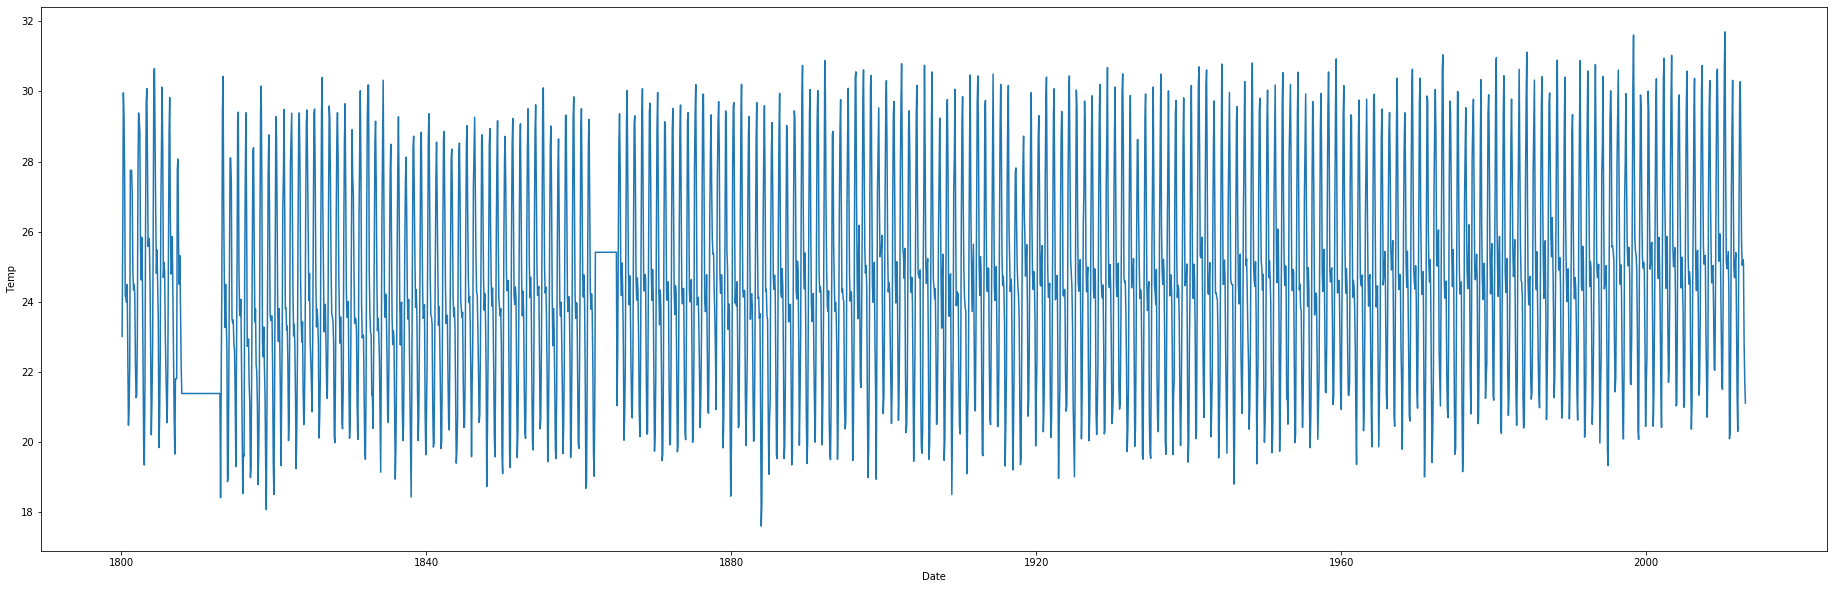

In [20]:
plt.figure(figsize=(32,10))
sns.lineplot(x=punecity.index, y=punecity['Temp'])
plt.show()

In [21]:
punecity['Month'] = punecity.index.month
punecity['Year'] = punecity.index.year
punecity

,Temp,Month,Year
Date,,,
1800-01-31,23.009,1,1800
1800-02-28,25.706,2,1800
1800-03-31,29.961,3,1800
1800-04-30,29.353,4,1800
1800-05-31,27.647,5,1800
...,...,...,...
2012-08-31,25.208,8,2012
2012-09-30,25.093,9,2012
2012-10-31,22.805,10,2012


In [22]:
punepivot = pd.pivot_table(punecity, values='Temp', index='Month', columns='Year', aggfunc='mean')
punepivot

Year,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Month,,,,,,,,,,,,,,,,,,,,,
1,23.009,22.162,23.064,21.705,22.649,22.382,22.210,21.804,21.382,21.382,...,24.476,23.621,23.374,24.321,23.606,22.348,24.518,24.162,23.113,23.359
2,25.706,27.751,27.536,26.078,25.987,26.567,25.644,21.804,21.382,21.382,...,27.294,28.128,26.701,26.355,27.231,27.007,27.601,27.960,27.035,26.224
3,29.961,27.751,29.388,29.672,30.559,28.462,28.814,21.804,21.382,21.382,...,29.816,29.730,29.430,29.219,30.019,29.433,30.498,30.746,28.986,29.704
4,29.353,27.751,29.200,30.083,30.654,30.120,29.826,27.791,21.382,21.382,...,31.030,29.902,30.583,30.375,30.738,30.314,30.639,31.700,30.319,30.279
5,27.647,27.103,28.825,28.080,28.466,28.425,26.410,28.072,21.382,21.382,...,28.030,27.084,28.304,27.249,27.733,27.232,28.616,27.834,27.096,28.131
6,24.163,24.882,25.601,25.580,26.474,24.695,24.790,25.563,21.382,21.382,...,25.477,25.341,25.232,24.926,25.585,25.523,25.157,25.144,24.965,25.671
7,24.127,24.337,24.621,25.813,24.812,25.123,24.864,24.493,21.382,21.382,...,24.998,24.395,24.504,24.315,25.072,24.536,25.458,24.941,24.688,25.043
8,23.983,24.504,25.841,25.711,25.479,24.820,25.862,25.313,21.382,21.382,...,25.156,25.270,24.857,25.421,25.302,24.865,25.936,25.182,25.092,25.208
9,24.492,24.193,24.746,24.540,24.409,23.145,24.080,23.718,21.382,21.382,...,25.543,24.600,24.608,25.467,25.321,25.032,24.992,25.435,25.400,25.093


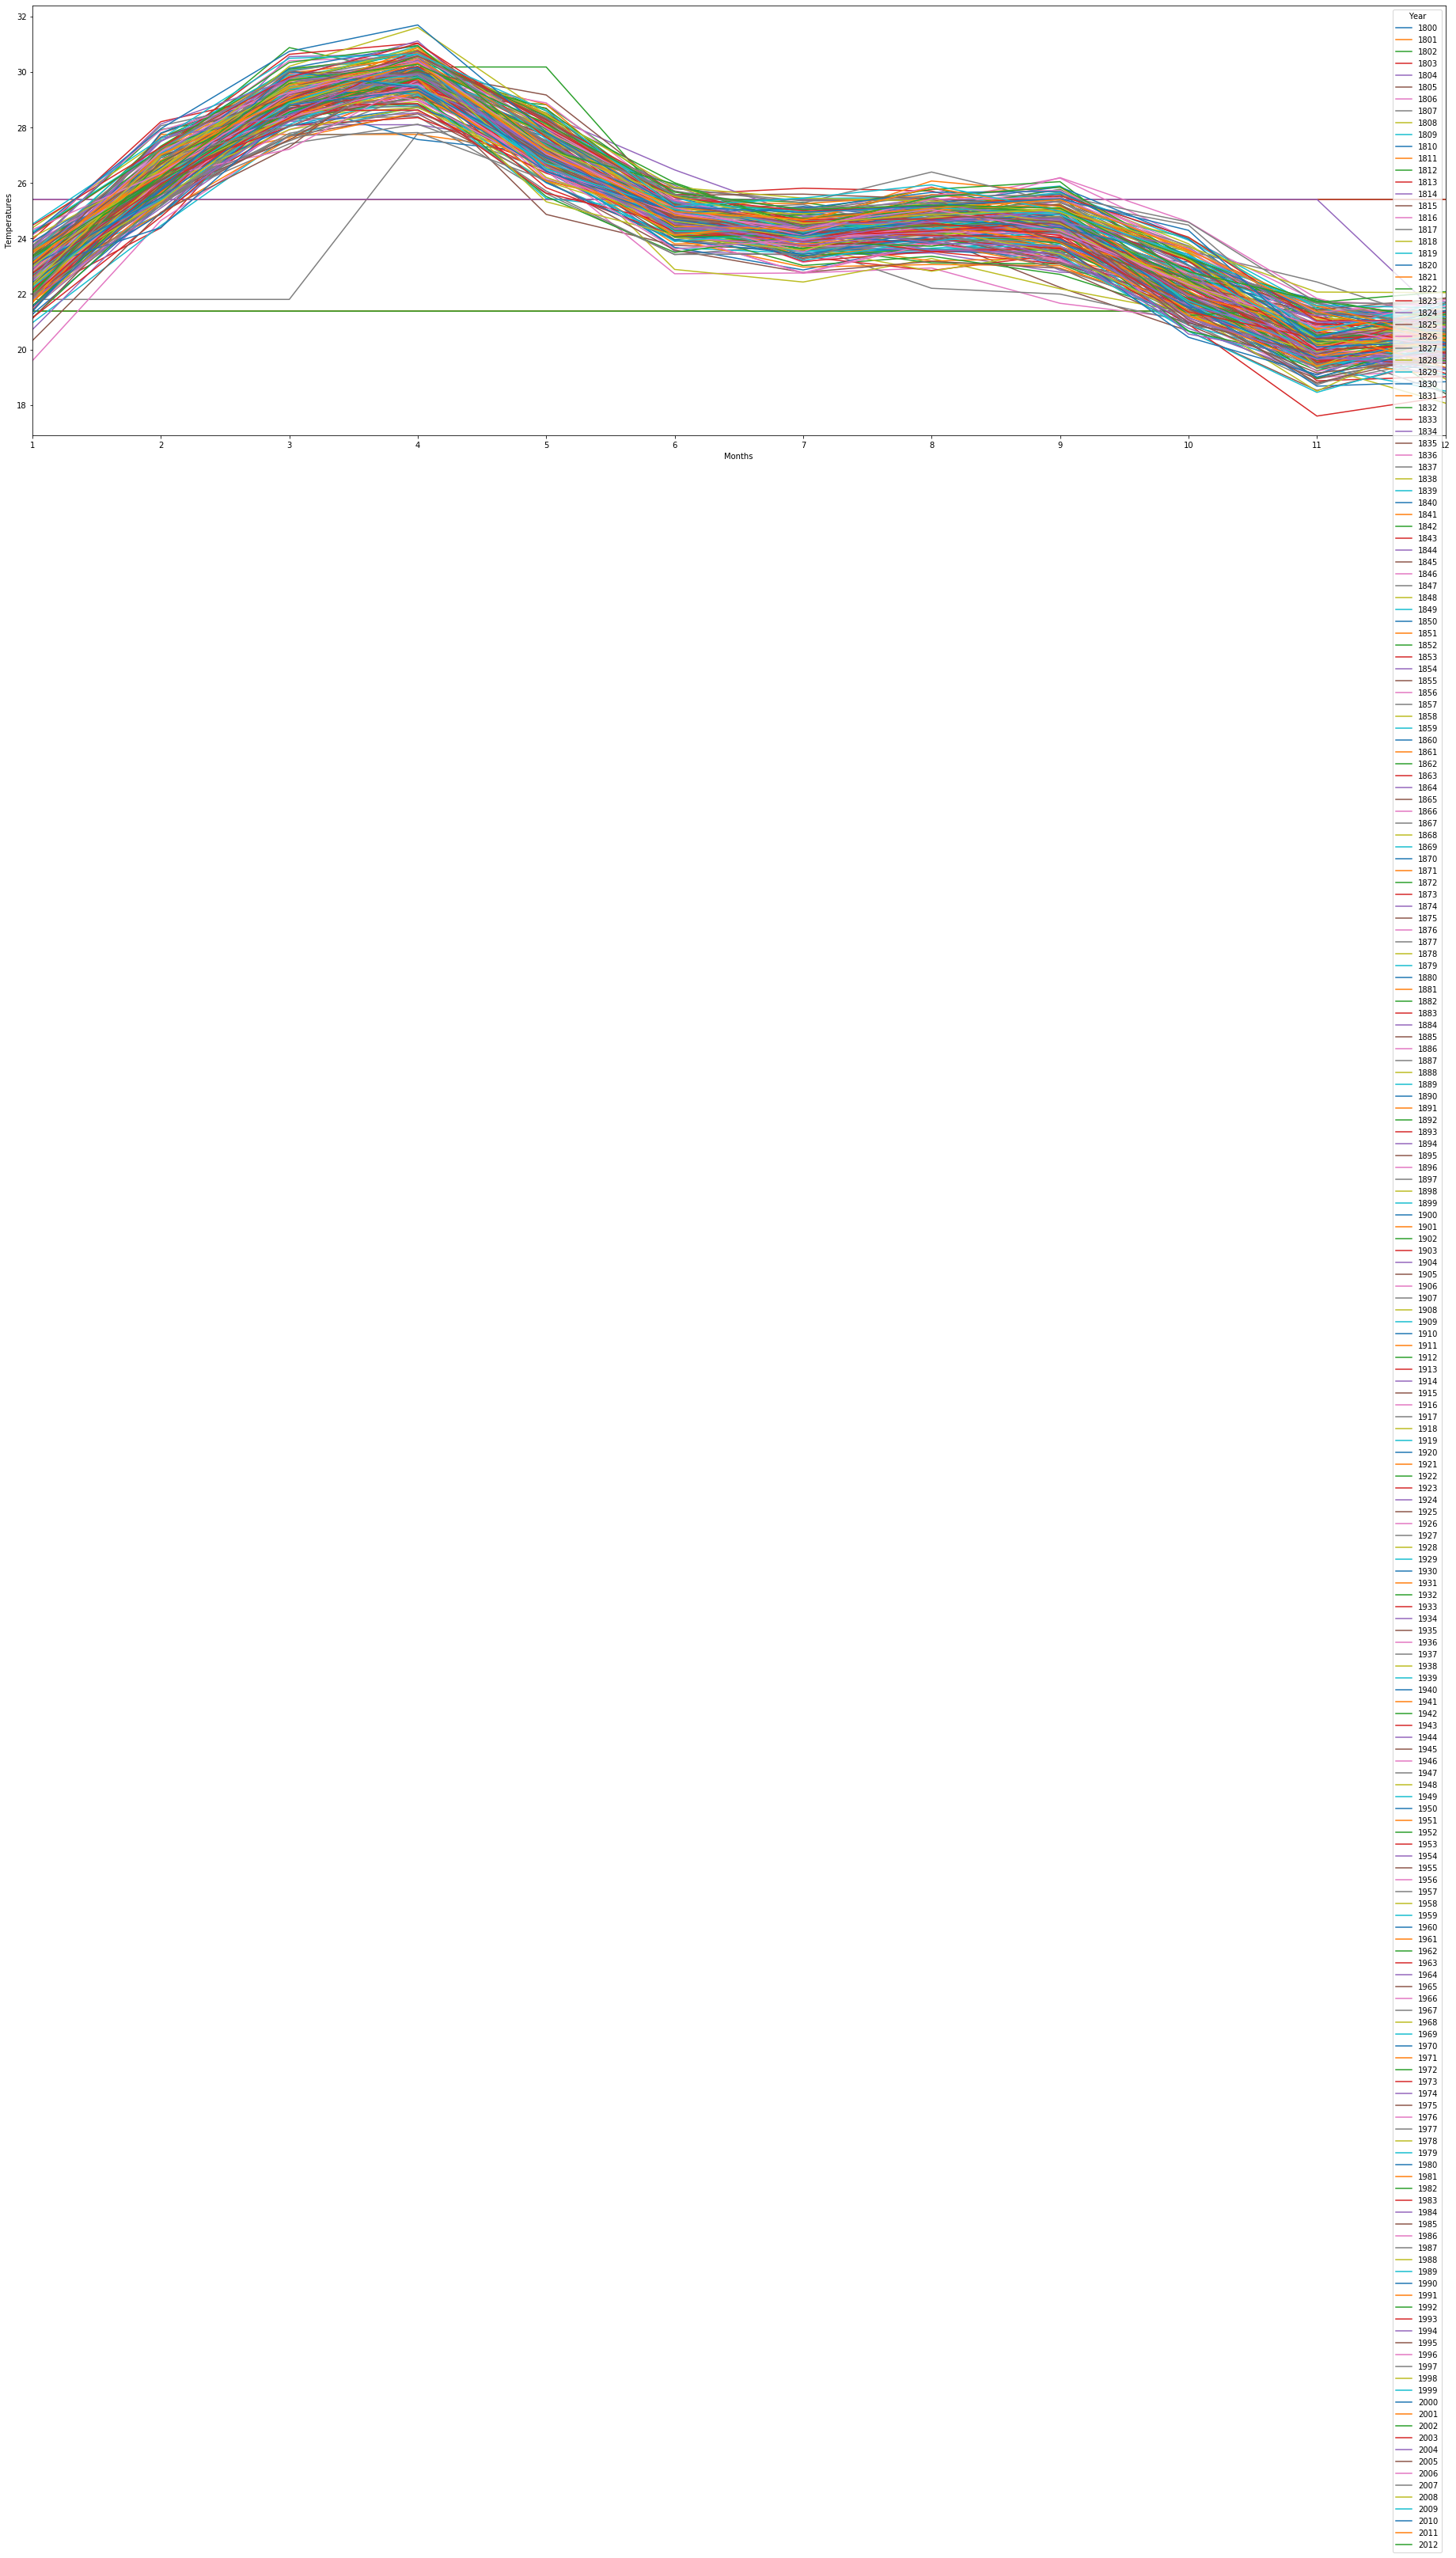

In [23]:
punepivot.plot(figsize=(32,10))
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.show()

In [24]:
monthlyAvg = punepivot.mean(axis=1)

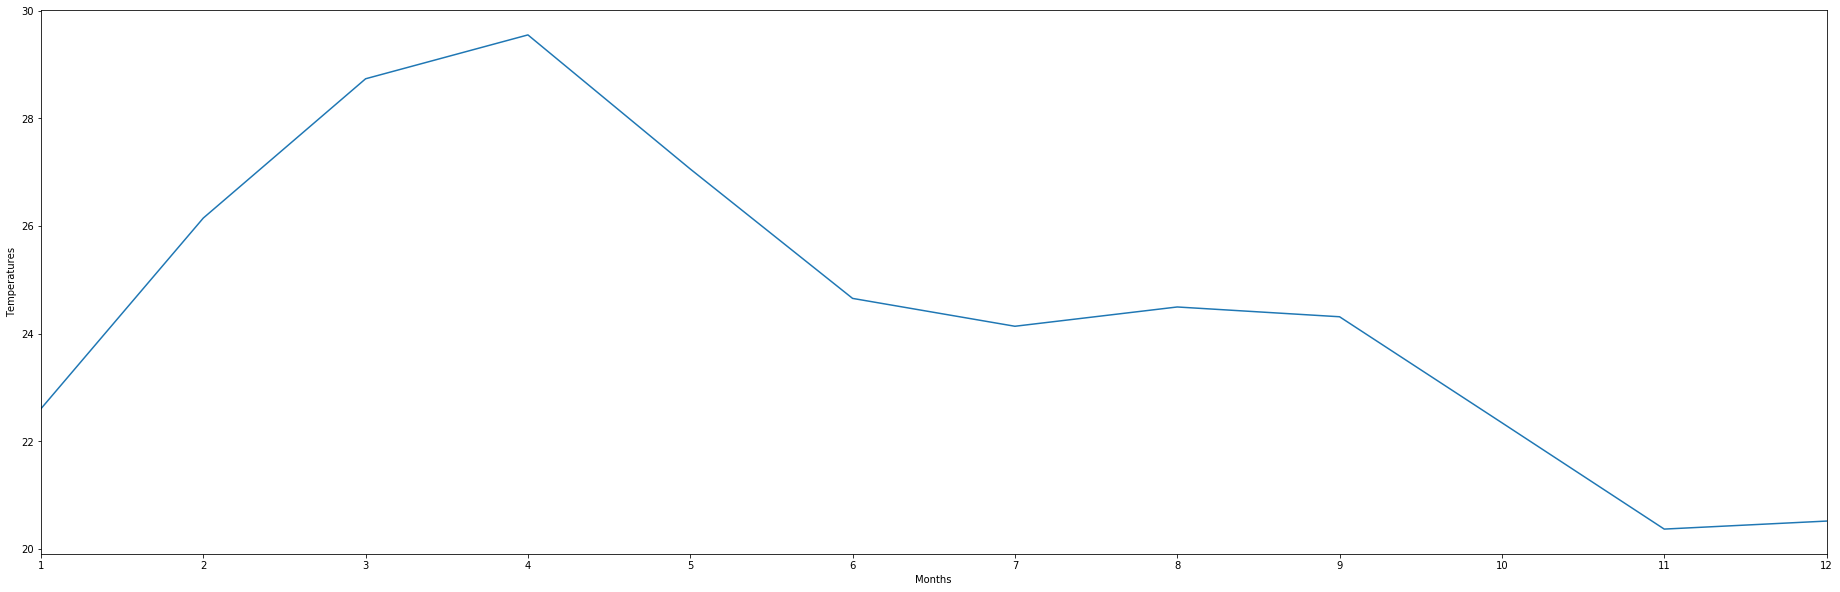

In [25]:
monthlyAvg.plot(figsize=(32,10))
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.show()

In [26]:
yearlyAvg = pd.pivot_table(punecity, values='Temp', index='Year', aggfunc = 'mean')
yearlyAvg

,Temp
Year,
1800,24.696000
1801,24.607500
1802,25.014083
1803,25.101250
1804,25.285833
...,...
2008,25.342083
2009,25.822667
2010,25.648000


In [27]:
yearlyAvg['10 years Moving Average'] = yearlyAvg['Temp'].rolling(10).mean()
yearlyAvg

,Temp,10 years Moving Average
Year,,
1800,24.696000,NaN
1801,24.607500,NaN
1802,25.014083,NaN
1803,25.101250,NaN
1804,25.285833,NaN
...,...,...
2008,25.342083,25.357108
2009,25.822667,25.416542
2010,25.648000,25.472150


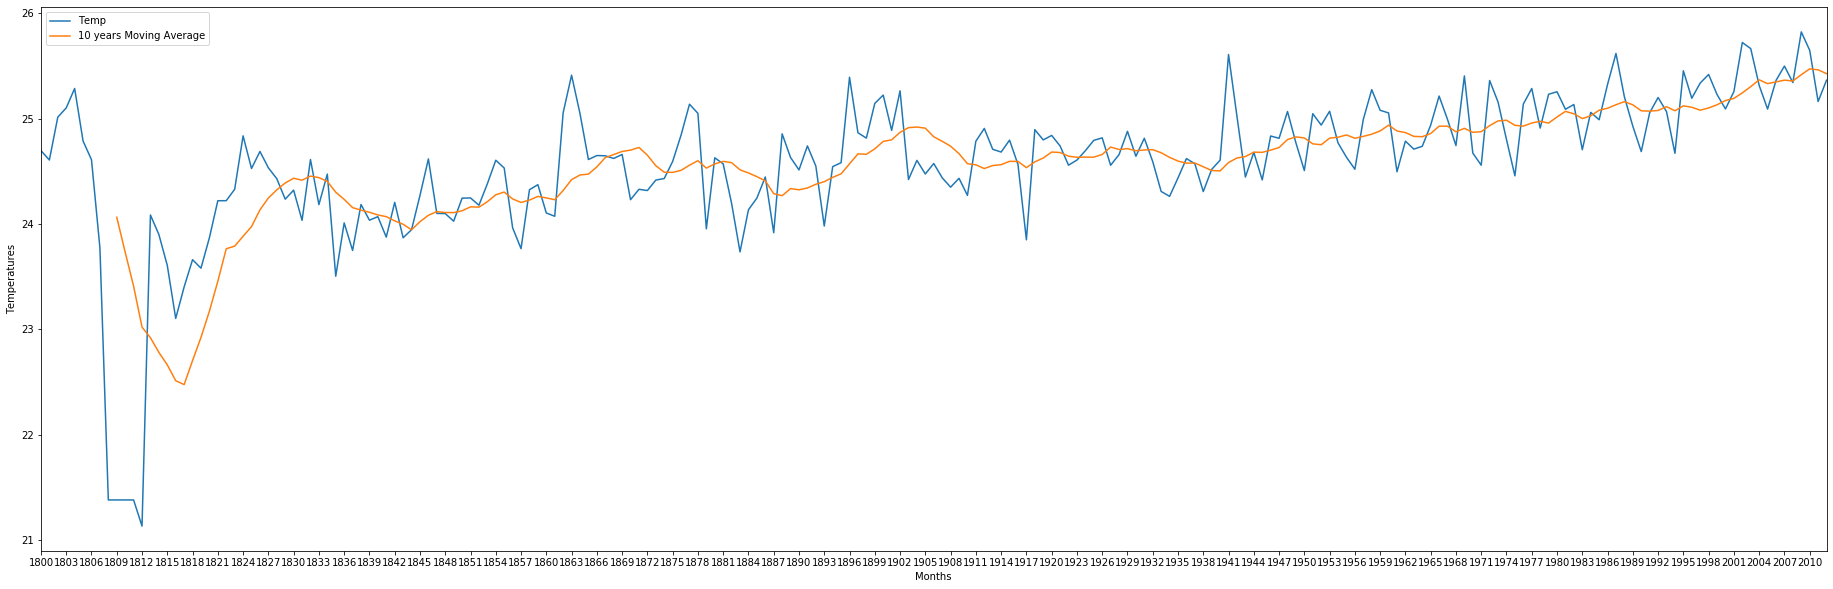

In [28]:
yearlyAvg[['Temp','10 years Moving Average']].plot(figsize=(32,10))
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1800, 2012, 3)])
plt.show()

In [29]:
train = punecity[:-60].copy()
valid = punecity[-60:-12].copy()
test = punecity[-12:].copy()

In [30]:
valid

,Temp,Month,Year
Date,,,
2008-01-31,22.348,1,2008
2008-02-29,27.007,2,2008
2008-03-31,29.433,3,2008
2008-04-30,30.314,4,2008
2008-05-31,27.232,5,2008
2008-06-30,25.523,6,2008
2008-07-31,24.536,7,2008
2008-08-31,24.865,8,2008
2008-09-30,25.032,9,2008


In [31]:
baseline = valid['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-02-29    22.348
2008-03-31    27.007
2008-04-30    29.433
2008-05-31    30.314
2008-06-30    27.232
Freq: M, Name: Temp, dtype: float64

In [32]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values

rmse_base = measure_rmse(valid.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 2.1565 celsius degrees


In [33]:
#doing the same for boston for comparison
bostoncity = cities.loc[cities['City'] == 'Boston',['dt','City','AverageTemperature']]

In [34]:
bostoncity.columns=['Date','City','Temp']
bostoncity=bostoncity.reindex(columns=['Date','City','Temp'])
bostoncity['Date'] = pd.to_datetime(bostoncity['Date'])
bostoncity.reset_index(drop=True, inplace=True)
bostoncity

,Date,City,Temp
0,1743-11-01,Boston,1.188
1,1743-12-01,Boston,NaN
2,1744-01-01,Boston,NaN
3,1744-02-01,Boston,NaN
4,1744-03-01,Boston,NaN
...,...,...,...
3234,2013-05-01,Boston,14.309
3235,2013-06-01,Boston,19.313
3236,2013-07-01,Boston,23.629
3237,2013-08-01,Boston,19.579


In [35]:
bostoncity.set_index('Date', inplace=True)

In [36]:
bostoncity = bostoncity.loc['1800':'2013-01-01']
bostoncity

,City,Temp
Date,,
1800-01-01,Boston,-6.134
1800-02-01,Boston,-5.164
1800-03-01,Boston,-0.788
1800-04-01,Boston,8.364
1800-05-01,Boston,12.642
...,...,...
2012-09-01,Boston,16.115
2012-10-01,Boston,10.966
2012-11-01,Boston,2.938


In [37]:
del bostoncity['City']

In [38]:
bostoncity.isnull().sum()

Temp    0
dtype: int64

In [39]:
bostoncity1 = bostoncity.copy() #BOOKMARK 

In [40]:
bostoncity = bostoncity.asfreq('M', method='bfill')
bostoncity

,Temp
Date,
1800-01-31,-5.164
1800-02-28,-0.788
1800-03-31,8.364
1800-04-30,12.642
1800-05-31,18.786
...,...
2012-08-31,16.115
2012-09-30,10.966
2012-10-31,2.938


In [41]:
bostoncity.head()
len(bostoncity)

2556

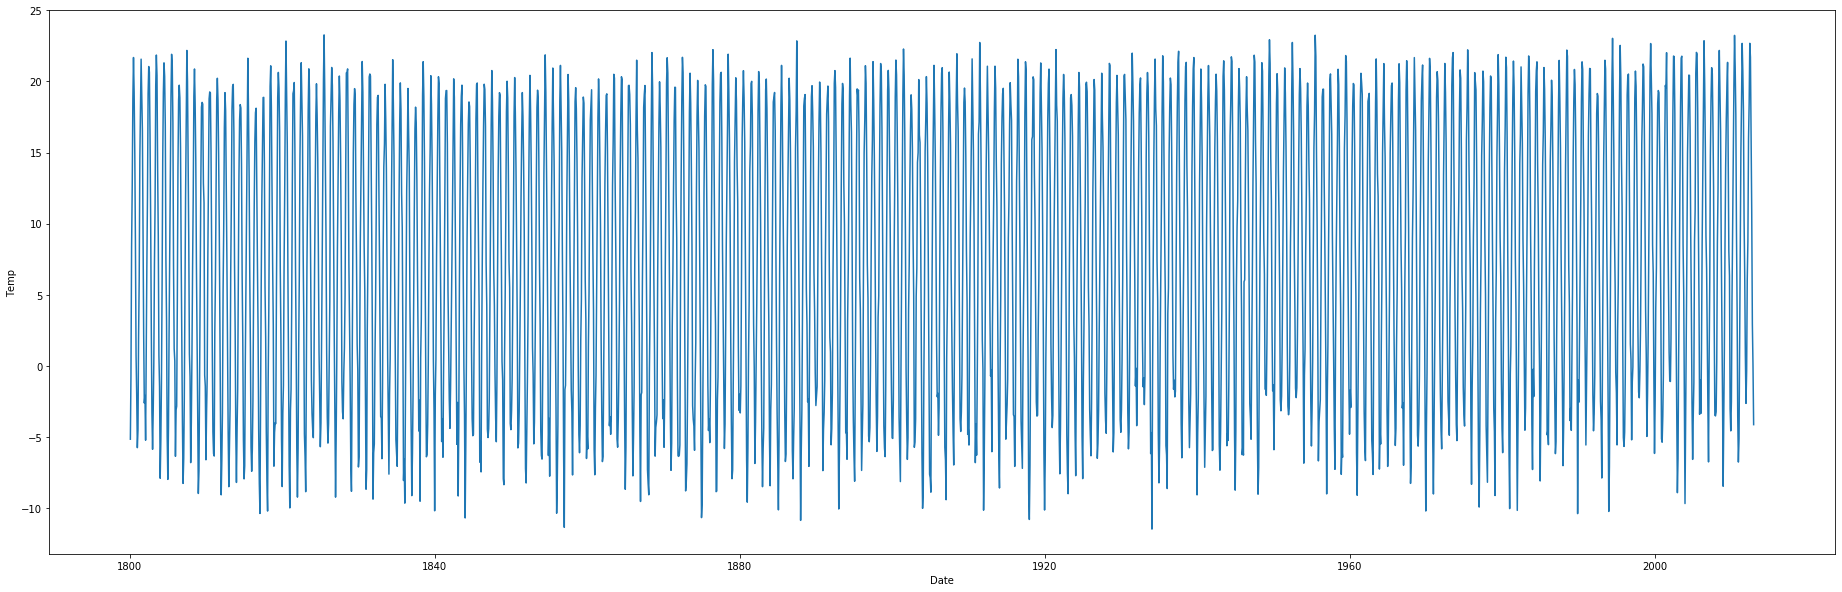

In [42]:
plt.figure(figsize=(32,10))
sns.lineplot(x=bostoncity.index, y=bostoncity['Temp'])
plt.show()

In [43]:
bostoncity['Month'] = bostoncity.index.month
bostoncity['Year'] = bostoncity.index.year
bostoncity

,Temp,Month,Year
Date,,,
1800-01-31,-5.164,1,1800
1800-02-28,-0.788,2,1800
1800-03-31,8.364,3,1800
1800-04-30,12.642,4,1800
1800-05-31,18.786,5,1800
...,...,...,...
2012-08-31,16.115,8,2012
2012-09-30,10.966,9,2012
2012-10-31,2.938,10,2012


In [44]:
bostonpivot = pd.pivot_table(bostoncity, values='Temp', index='Month', columns='Year', aggfunc='mean')
bostonpivot

Year,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Month,,,,,,,,,,,,,,,,,,,,,
1,-5.164,-4.537,-5.234,-3.132,-5.265,-4.288,-3.099,-6.530,-3.961,-7.384,...,-6.499,-3.912,-3.359,-3.347,-6.761,-3.243,-3.224,-2.522,-5.149,-0.363
2,-0.788,1.946,0.766,0.160,-1.229,2.137,-2.844,-2.345,0.694,-1.437,...,0.596,1.978,-1.188,1.121,0.149,0.288,1.084,4.565,0.868,6.094
3,8.364,6.145,6.801,7.162,5.691,7.989,4.434,5.398,6.918,6.487,...,5.720,7.967,8.741,8.552,5.866,8.681,8.698,9.957,8.164,8.753
4,12.642,14.569,11.807,11.341,14.422,13.545,13.910,11.902,11.823,12.861,...,12.499,14.919,10.988,13.424,14.797,12.455,13.984,15.844,14.984,15.946
5,18.786,18.104,19.133,19.672,19.198,18.968,18.659,17.092,18.950,18.196,...,18.189,17.665,20.581,19.281,18.786,19.606,17.397,19.733,18.560,18.533
6,21.683,21.567,21.049,21.856,21.307,21.910,19.736,22.181,20.877,18.526,...,21.645,20.446,22.043,22.862,20.967,22.182,19.651,23.241,22.676,22.683
7,19.222,19.160,20.655,20.420,20.374,21.131,18.842,19.987,18.454,18.407,...,21.776,20.426,21.930,19.866,20.555,19.271,21.340,20.953,20.769,21.702
8,14.926,16.522,16.255,13.766,16.920,17.079,15.355,14.336,14.491,12.846,...,16.637,16.537,17.957,15.376,16.976,16.482,15.011,17.673,17.891,16.115
9,8.780,8.928,10.378,9.143,7.491,7.050,7.971,8.803,7.222,11.457,...,8.476,9.288,10.381,9.131,12.532,8.704,8.064,9.620,10.333,10.966


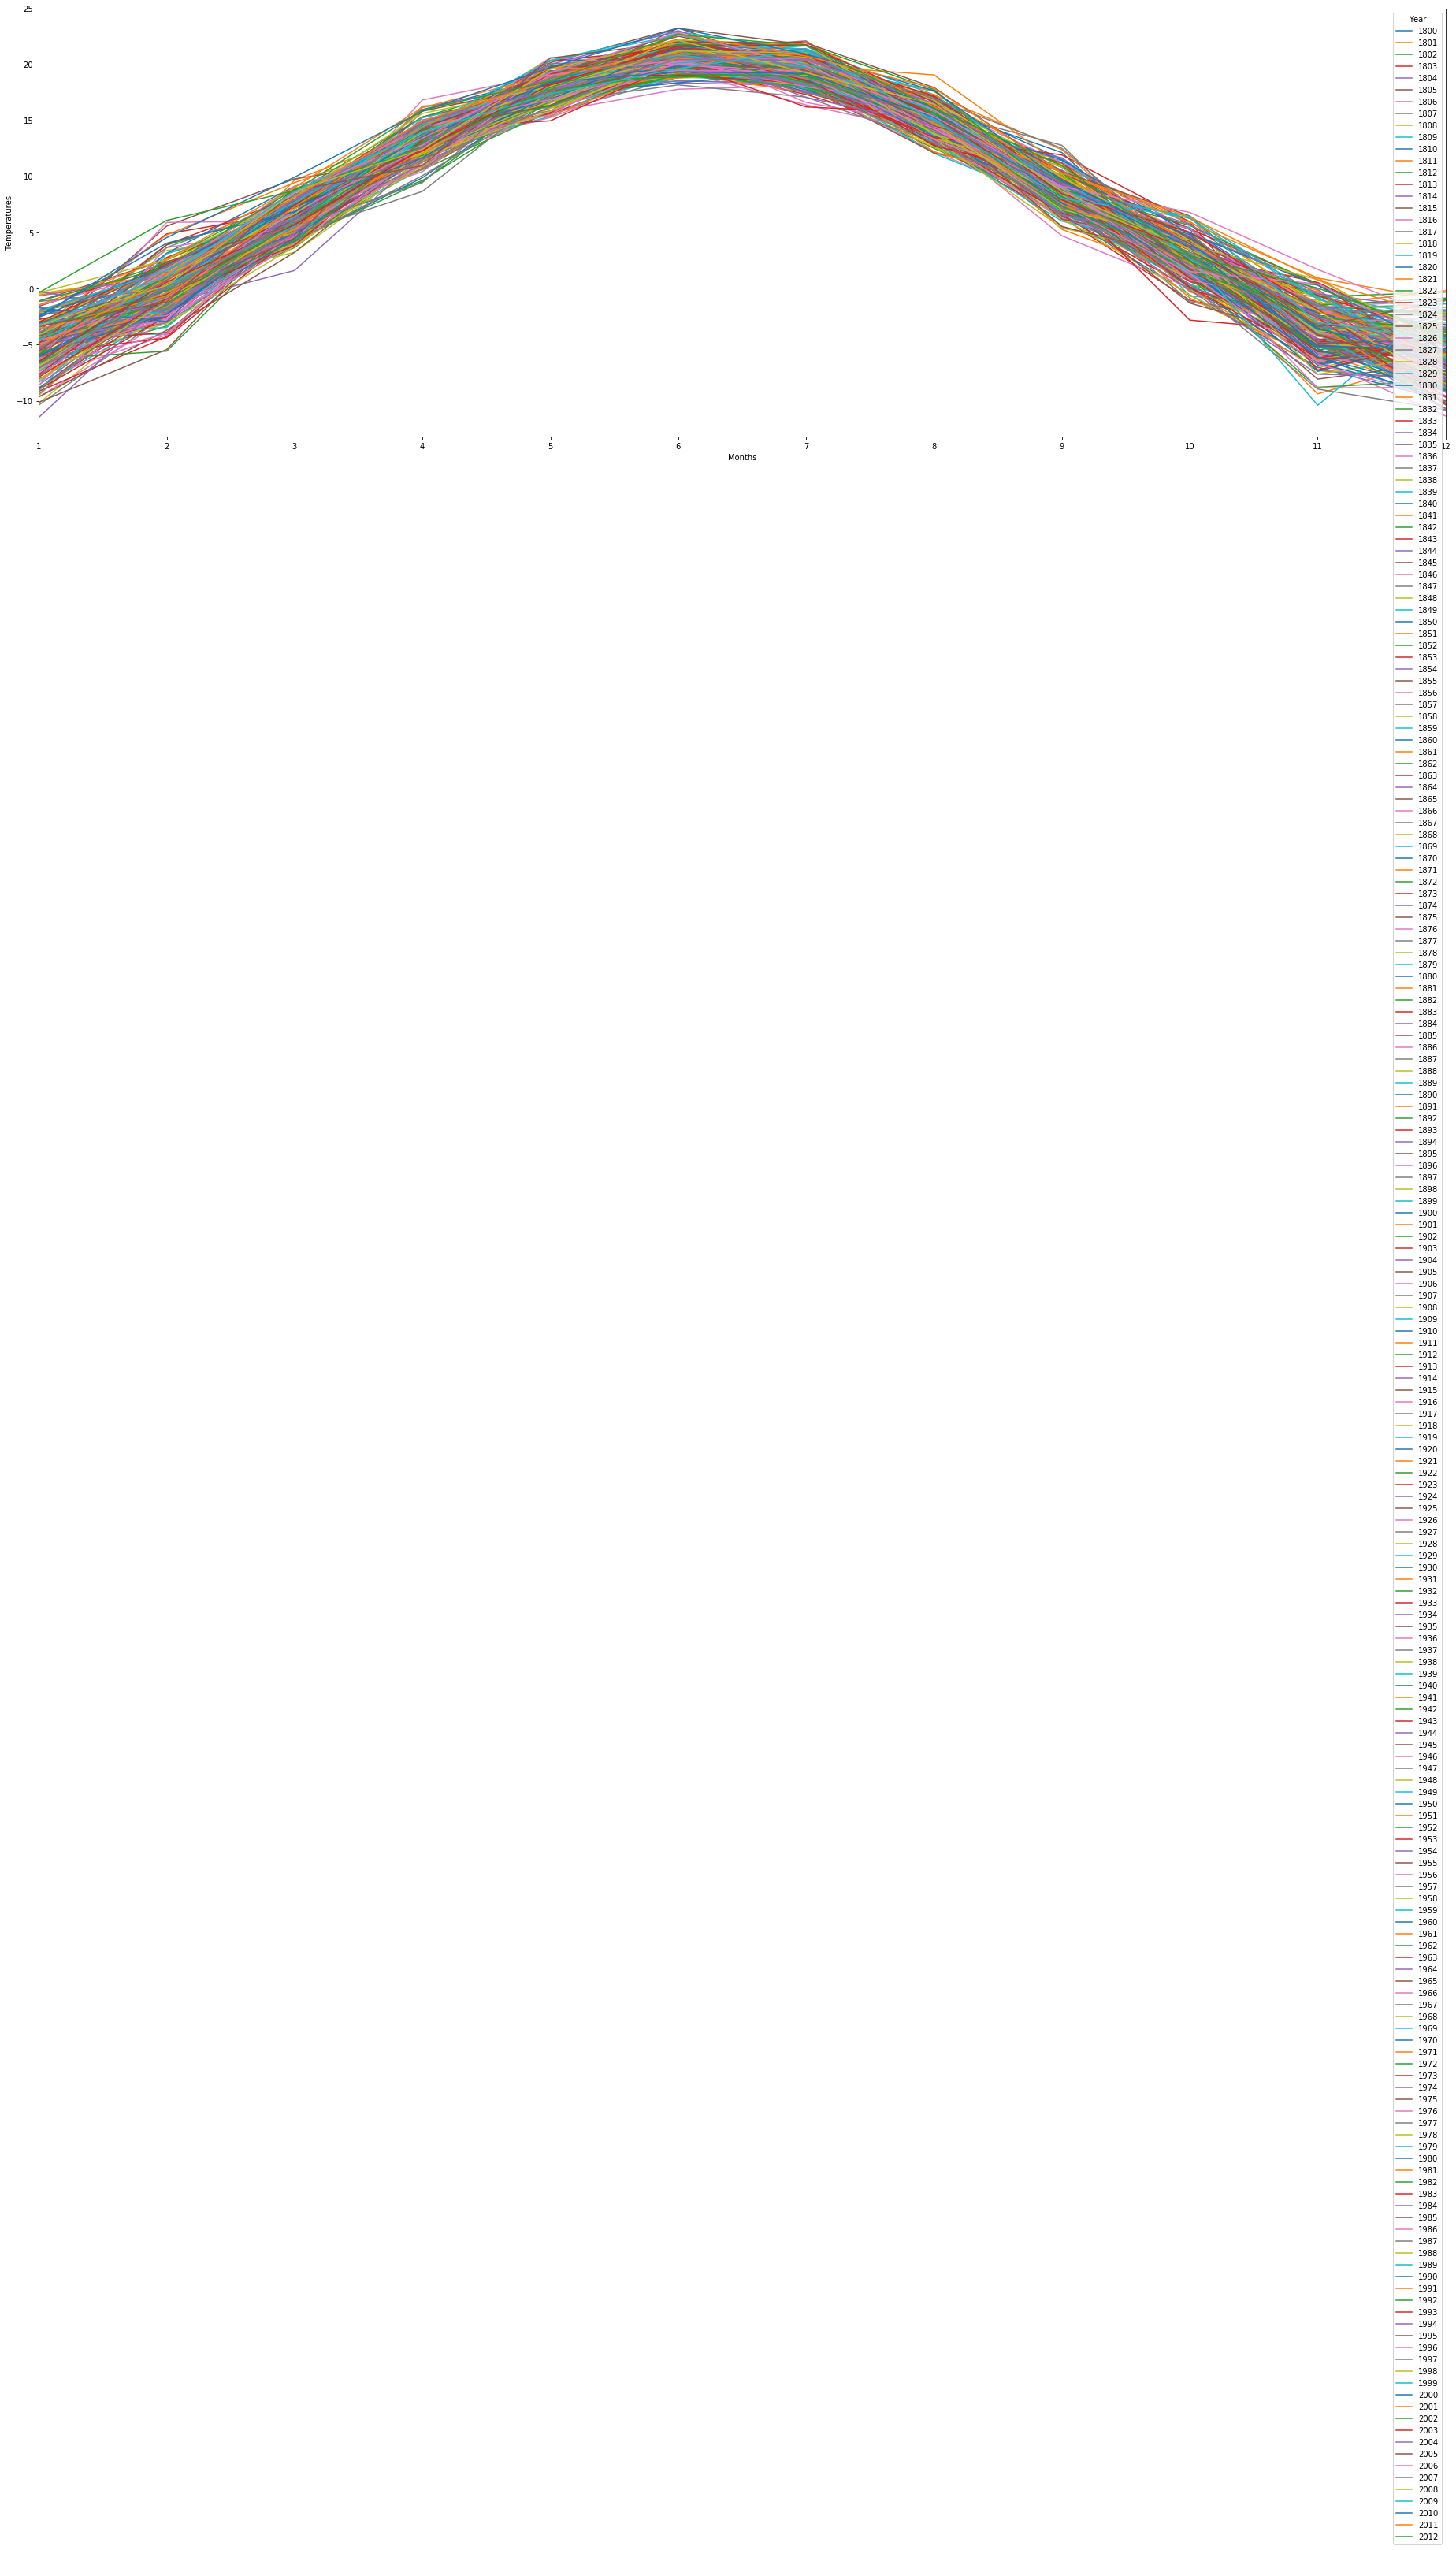

In [45]:
bostonpivot.plot(figsize=(32,10))
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.show()

In [46]:
monthlyAvg1 = bostonpivot.mean(axis=1)
monthlyAvg1

Month
1     -5.076413
2     -0.050352
3      6.412577
4     12.924545
5     18.051610
6     20.713582
7     19.437432
8     15.094563
9      8.714920
10     2.689573
11    -3.612568
12    -6.038282
dtype: float64

Comparing the temperature variations between Pune City and Boston City based on the average temperatures taken over all the years for each month.

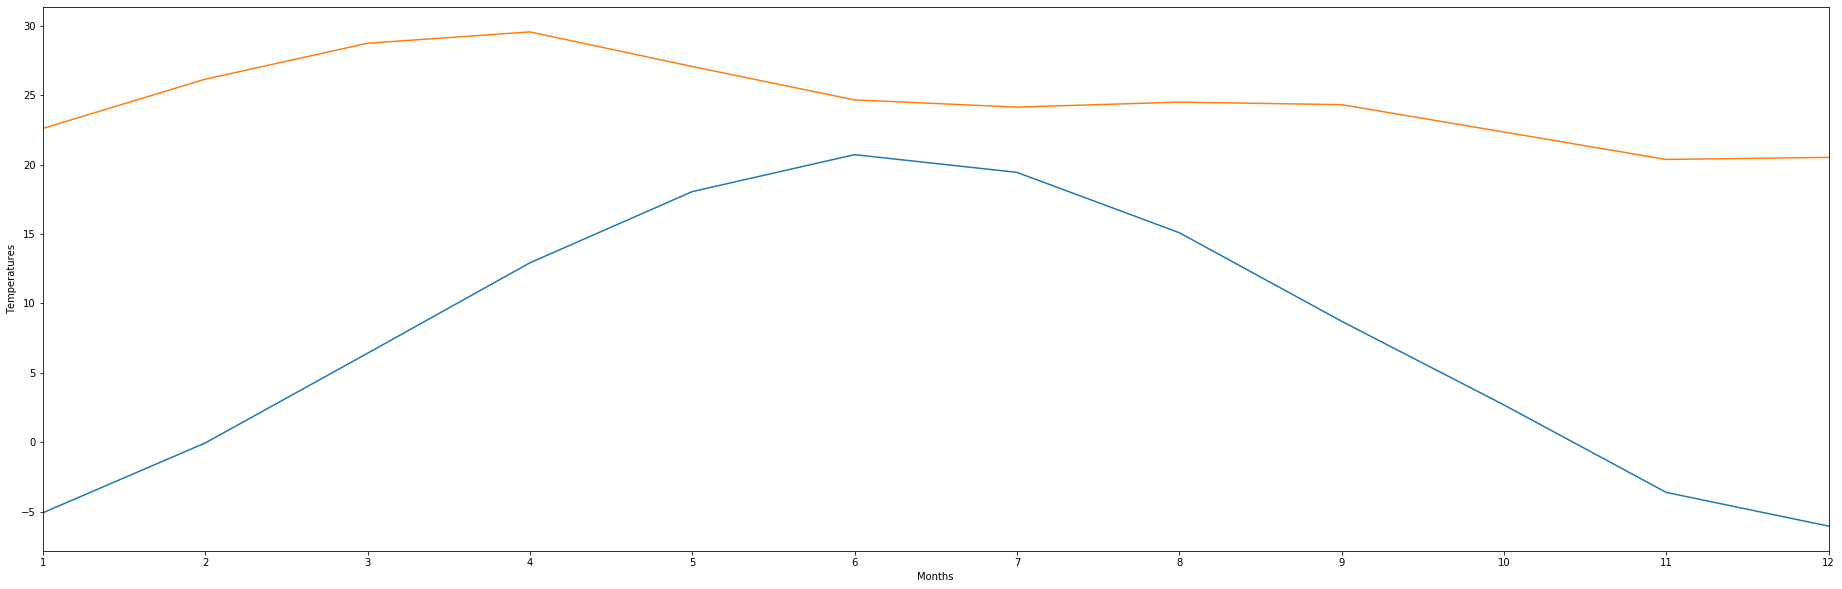

In [47]:
#for boston
monthlyAvg1.plot(figsize=(32,10))
#for pune
monthlyAvg.plot(figsize=(32,10))
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.show()

For better visual results, we compared the same using bar graphs.

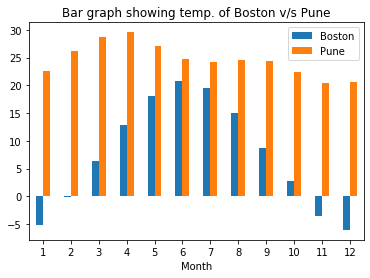

In [48]:
#bar graph comparison
df = pd.DataFrame({'Boston': monthlyAvg1, 'Pune': monthlyAvg})
ax = df.plot.bar(title='Bar graph showing temp. of Boston v/s Pune',rot=0)

#we can add color variations, like a darker color for high value and lighter for low
#i tried finding a lot of it, didnt work

In [49]:
yearlyAvg = pd.pivot_table(bostoncity, values='Temp', index='Year', aggfunc = 'mean')
yearlyAvg

,Temp
Year,
1800,7.619417
1801,8.320333
1802,7.919750
1803,7.644417
1804,7.422583
...,...
2008,8.121417
2009,8.393583
2010,9.397417


In [50]:
yearlyAvg['10 years Moving Average'] = yearlyAvg['Temp'].rolling(10).mean()
yearlyAvg

,Temp,10 years Moving Average
Year,,
1800,7.619417,NaN
1801,8.320333,NaN
1802,7.919750,NaN
1803,7.644417,NaN
1804,7.422583,NaN
...,...,...
2008,8.121417,8.573983
2009,8.393583,8.492883
2010,9.397417,8.626158


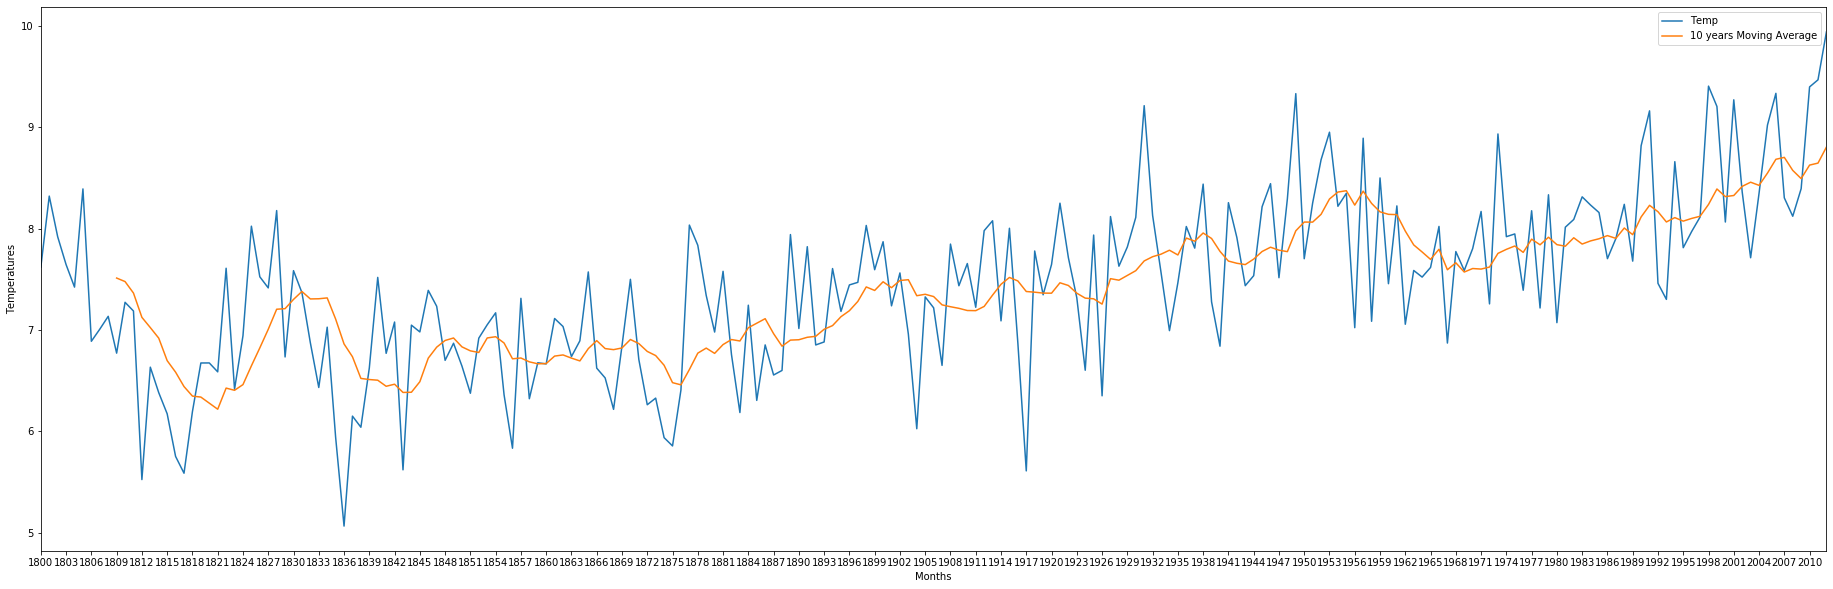

In [51]:
yearlyAvg[['Temp','10 years Moving Average']].plot(figsize=(32,10))
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1800, 2012, 3)])
plt.show()

In [52]:
train = bostoncity[:-60].copy()
valid = bostoncity[-60:-12].copy()
test = bostoncity[-12:].copy()

In [53]:
baseline = valid['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-02-29    -3.243
2008-03-31     0.288
2008-04-30     8.681
2008-05-31    12.455
2008-06-30    19.606
Freq: M, Name: Temp, dtype: float64

In [54]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values

rmse_base = measure_rmse(valid.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 5.2288 celsius degrees


In [254]:
pip install chart_studio

Note: you may need to restart the kernel to use updated packages.


In [256]:
pip install cufflinks

  Created wheel for cufflinks: filename=cufflinks-0.17.3-cp37-none-any.whl size=68730 sha256=744a1e29c95b4c7c8fa495dafc6094d40345765c7ffd9959b04040989acab69e
  Stored in directory: C:\Users\19293\AppData\Local\pip\Cache\wheels\7d\ba\8d\38b672c3e40d8bd22dd60b8e6e29965b43f2b4be4d064e44d5
Successfully built cufflinks
Note: you may need to restart the kernel to use updated packages.


Using chart_studio and cufflinks library to plot interactive user friendly graphs for Boston City with zoom-in/out features

In [55]:
# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [56]:
monthlyAvg1.iplot(kind='line', xTitle='Month', color='#3393FF',
                  yTitle='Average Temperature', title='Average monthly temperature over the years')


In [58]:
country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
country

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [59]:
del country['AverageTemperatureUncertainty']

In [60]:
country.columns=['Date', 'AvgTemp', 'Country']
country = country.reindex(columns=['Date','AvgTemp','Country'])
country

,Date,AvgTemp,Country
0,1743-11-01,4.384,Åland
1,1743-12-01,NaN,Åland
2,1744-01-01,NaN,Åland
3,1744-02-01,NaN,Åland
4,1744-03-01,NaN,Åland
...,...,...,...
577457,2013-05-01,19.059,Zimbabwe
577458,2013-06-01,17.613,Zimbabwe
577459,2013-07-01,17.000,Zimbabwe
577460,2013-08-01,19.759,Zimbabwe


In [61]:
country['Date'] = pd.to_datetime(country['Date'])
country.set_index('Date', inplace=True)
country

,AvgTemp,Country
Date,,
1743-11-01,4.384,Åland
1743-12-01,NaN,Åland
1744-01-01,NaN,Åland
1744-02-01,NaN,Åland
1744-03-01,NaN,Åland
...,...,...
2013-05-01,19.059,Zimbabwe
2013-06-01,17.613,Zimbabwe
2013-07-01,17.000,Zimbabwe


In [62]:
#country['AvgTemp'].fillna( method ='ffill', inplace = True) 

In [63]:
x = country.copy()

In [64]:
x.index = country.index.year

In [65]:
country.index.year

Int64Index([1743, 1743, 1744, 1744, 1744, 1744, 1744, 1744, 1744, 1744,
            ...
            2012, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013],
           dtype='int64', name='Date', length=577462)

In [66]:
y = x.groupby(['Country','Date']).mean()

In [67]:
z = y.reset_index()

In [68]:
geodata=z[(z['Date']== 2000)]
geodata

,Country,Date,AvgTemp
162,Afghanistan,2000,15.497833
326,Africa,2000,24.588083
597,Albania,2000,13.746583
824,Algeria,2000,24.032250
971,American Samoa,2000,27.219833
...,...,...,...
47492,Western Sahara,2000,23.020083
47630,Yemen,2000,27.436167
47794,Zambia,2000,21.558750
47958,Zimbabwe,2000,21.149000


In [69]:
init_notebook_mode(connected=True)
# Read Data

# Create the Choropleth
fig = go.Figure(data=go.Choropleth(
    locations = geodata['Country'],
    locationmode = 'country names',
    z = geodata['AvgTemp'],
    colorscale = 'Reds',
    marker_line_color = 'black',
    marker_line_width = 0.5,
))
fig.update_layout(
    title_text = 'Geo plot of Average Temperature for year 2000',
    title_x = 0.5,
    geo=dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)